In [1]:
import os

import numpy as np
import pandas as pd
import scipy
# import polars as pl # Prove this is quickler
import matplotlib.pyplot as plt

import astropy
 
import torch
from torch import nn
from torch.utils.data import TensorDataset, Dataset, DataLoader
import lightning as L

from tqdm.auto import tqdm

import lcdata

from preprocess_light_curve import *

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [2]:
def plot_light_curve(light_curve, oid:any = None):

    time = light_curve['mjd'].to_numpy()
    mag  = light_curve['magpsf'].to_numpy()

    fig, ax = plt.subplots()
    ax.plot(time,mag,'o')
    ax.set_xlabel('MJD')
    ax.set_ylabel('Apparent magnitude')
    ax.set_ylim(ax.get_ylim()[::-1])

    if oid != None:
        ax.set_title(f'oid: {oid}')

In [3]:
object_table = pd.read_pickle('~/Supernovae_DeepLearning/object_ZTF_ALeRCE_19052024.pkl')
object_table

,oid,source_id,firstmjd,Av_MW,true_label
0,ZTF24aanbjel,2024iqx,60440.299120,0.0287,SN
1,ZTF24aamkufg,2024igh,60437.289560,0.0261,SNIa
2,ZTF24aajnwwr,2024hqr,60429.209850,0.0509,SNIa
3,ZTF18aaeopbs,2024glo,60407.202211,0.1403,SNIa
4,ZTF24aamtsgz,2024ipf,60438.397951,0.2484,SNIa
...,...,...,...,...,...
10868,ZTF19aamqjsh,2016cda,58558.284549,0.0447,SNIa
10869,ZTF18aarefgc,2016bey,60315.469572,0.0355,SNIa
10870,ZTF18aajleyh,2016ayf,58276.285139,0.0533,SNIa
10871,ZTF22abntkbk,2016nx,59870.374664,0.5834,SNIa


In [4]:
lightcurves_alercextns = pd.read_pickle('/home/jurados/Supernovae_DeepLearning/data/lightcurves/lcs_transients_20240517.pkl')
lightcurves_alercextns

,oid,candid,rfid,mjd,fid,magpsf,sigmapsf
0,ZTF19abgpgyp,1515523874715015006,681120247.0,59269.523877,2,20.385720,0.211641
1,ZTF19abgpgyp,1499511354715015014,NaN,59253.511354,2,20.678400,0.258971
2,ZTF19abgpgyp,1502430264715015014,NaN,59256.430266,2,20.652500,0.269586
3,ZTF19abgpgyp,1510536184715015009,NaN,59264.536181,2,20.663600,0.299923
4,ZTF18abjswhy,1515520891415015005,685120214.0,59269.520891,2,16.079460,0.030863
...,...,...,...,...,...,...,...
4546324,ZTF19ablwbut,1508538592115015009,NaN,59262.538599,1,17.079200,0.062217
4546325,ZTF19ablwbut,1511512652115015011,NaN,59265.512651,1,17.125100,0.057529
4546326,ZTF19ablwbut,1513537042115015020,NaN,59267.537049,1,17.073800,0.073881
4546327,ZTF19ablwbut,1515495032115015010,NaN,59269.495035,1,17.232900,0.056399


In [5]:
# Here I realized a crossmatch between all lightcurves_alercextns and
# the object table


,oid,candid,rfid,mjd,fid,magpsf,sigmapsf,source_id,firstmjd,Av_MW,true_label
0,ZTF19abgpgyp,1515523874715015006,681120247.0,59269.523877,2,20.385720,0.211641,2019lkw,58681.194086,0.0608,SNII
1,ZTF19abgpgyp,1499511354715015014,NaN,59253.511354,2,20.678400,0.258971,2019lkw,58681.194086,0.0608,SNII
2,ZTF19abgpgyp,1502430264715015014,NaN,59256.430266,2,20.652500,0.269586,2019lkw,58681.194086,0.0608,SNII
3,ZTF19abgpgyp,1510536184715015009,NaN,59264.536181,2,20.663600,0.299923,2019lkw,58681.194086,0.0608,SNII
4,ZTF19abgpgyp,1376156074715015007,NaN,59130.156076,1,20.678900,0.251519,2019lkw,58681.194086,0.0608,SNII
...,...,...,...,...,...,...,...,...,...,...,...
311883,ZTF19acfsbpa,1045488394515015015,575120245.0,58799.488391,2,19.018024,0.193011,2019tqt,58785.515266,0.0639,SNII
311884,ZTF19acfsbpa,1031515263215015003,574120232.0,58785.515266,2,18.899368,0.117825,2019tqt,58785.515266,0.0639,SNII
311885,ZTF19acfsbpa,1038517094515015002,575120245.0,58792.517095,2,18.934042,0.112121,2019tqt,58785.515266,0.0639,SNII
311886,ZTF19acfsbpa,1074567473215015008,574120232.0,58828.567477,2,19.440742,0.163406,2019tqt,58785.515266,0.0639,SNII


In [6]:
lightcurves = lightcurves[lightcurves.fid == 1]
lightcurves.oid.unique().size

7913

In [7]:
print('The oid of transients with maximum length is:', lightcurves.groupby(by='oid')['mjd'].size().idxmax())
print('The maximum length of observation is:', lightcurves.groupby(by='oid')['mjd'].size().max())

The oid of transients with maximum length is: ZTF18aainvic
The maximum length of observation is: 816


In [8]:
def pad_zeros(group, max_length=1730):
    
    group_length = len(group)

    if group_length < max_length:
        extra_rows = max_length - group_length
        extra_data = pd.DataFrame({
            'oid': [group['oid'].iloc[0]] * extra_rows,
            'mag': [0] * extra_rows
        })
        group = pd.concat([group, extra_data], ignore_index=True)

    return group

In [9]:
sn_unique = lightcurves.oid.unique()
selected_unique_values = np.random.choice(sn_unique, int(0.8 * len(sn_unique)), replace=False)
selected_unique_values_test = np.random.choice(sn_unique, int(0.2 * len(sn_unique)), replace=False)

In [10]:
train_data = lightcurves[lightcurves.oid.isin(selected_unique_values)]
test_data = lightcurves[lightcurves.oid.isin(selected_unique_values_test)]

In [11]:
print('The oid of transients with maximum length is:', train_data.groupby(by='oid')['mjd'].size().idxmax())
print('The maximum length of observation is:', train_data.groupby(by='oid')['mjd'].size().max())

The oid of transients with maximum length is: ZTF18aainvic
The maximum length of observation is: 816


In [12]:
# 1. Contar el número de ocurrencias en cada grupo
group_counts_train = train_data['oid'].value_counts()
group_counts_test = test_data['oid'].value_counts()

# 2. Filtrar los `oid` que cumplen con la condición de longitud
valid_oids_train = group_counts_train[(group_counts_train >= 100) & (group_counts_train <= 300)].index
valid_oids_test = group_counts_test[(group_counts_test >= 100) & (group_counts_test <= 300)].index

# 3. Filtrar el DataFrame original para mantener solo los grupos válidos
train_data = train_data[train_data['oid'].isin(valid_oids_train)]
test_data = test_data[test_data['oid'].isin(valid_oids_test)]

In [13]:
print('The oid of transients with maximum length is:', train_data.groupby(by='oid')['mjd'].size().idxmin())
print('The minimum length of observation is:', train_data.groupby(by='oid')['mjd'].size().min())

The oid of transients with maximum length is: ZTF20aazffau
The minimum length of observation is: 102


In [14]:
class SinteticLigthCurve:
    def __init__(self,tpt,a0,w0,p0,m0): #,P,Q,R):
        self.a0 = a0
        self.w0 = w0
        self.tpt = tpt
        self.p0 = p0
        self.m0 = m0
        #self.P = P
        #self.Q = Q
        #self.R = R

    def olivares(self,t):
        f_fd = -self.a0/(1+np.exp((t-self.tpt)/self.w0))
        f_ld = self.p0*(t-self.tpt)+self.m0
        #f_gs =  -self.P * np.exp(((t-self.Q)/self.R)**2)
        f = f_fd + f_ld # + f_gs
        return f

In [15]:
import scipy.interpolate


def process_light_curve_atat(light_curve):

    #new_light_curve = light_curve.copy()

    time = light_curve['mjd'].to_numpy()
    mag  = light_curve['magpsf'].to_numpy()

    f = scipy.interpolate.interp1d(time,mag, bounds_error=False, fill_value=0)

    if len(time) < 300:
        new_time = np.linspace(min(time), max(time), 300)
        new_mag  = f(new_time)

    else:
        new_time = time
        new_mag = mag

    new_light_curve = pd.DataFrame({
        'mjd':new_time,
        'magpsf': new_mag
    })

    return new_light_curve

In [17]:
one_light_curve = train_data[train_data.oid == train_data.oid.unique()[3]]
one_light_curve

,oid,candid,rfid,mjd,fid,magpsf,sigmapsf,source_id,firstmjd,Av_MW,true_label
2637,ZTF20acpjbgc,1537515091215015015,637120112.0,59291.515093,1,19.310745,0.093826,2020yzq,59164.118044,0.3809,SNII
2640,ZTF20acpjbgc,1543454421215015007,637120112.0,59297.454421,1,19.207111,0.161104,2020yzq,59164.118044,0.3809,SNII
2642,ZTF20acpjbgc,1547505551215015006,637120112.0,59301.505556,1,19.351406,0.179626,2020yzq,59164.118044,0.3809,SNII
2646,ZTF20acpjbgc,1556476301215015014,637120112.0,59310.476308,1,19.455116,0.102611,2020yzq,59164.118044,0.3809,SNII
2648,ZTF20acpjbgc,1559494401215015011,637120112.0,59313.494410,1,19.513597,0.119063,2020yzq,59164.118044,0.3809,SNII
...,...,...,...,...,...,...,...,...,...,...,...
3359,ZTF20acpjbgc,1501532801215015018,637120112.0,59255.532801,1,19.090400,0.085347,2020yzq,59164.118044,0.3809,SNII
3361,ZTF20acpjbgc,1497543911215015009,NaN,59251.543912,1,19.119000,0.092981,2020yzq,59164.118044,0.3809,SNII
3363,ZTF20acpjbgc,1504533031215015041,637120112.0,59258.533032,1,18.887754,0.121645,2020yzq,59164.118044,0.3809,SNII
3365,ZTF20acpjbgc,1509533051215015008,637120112.0,59263.533056,1,19.179640,0.174018,2020yzq,59164.118044,0.3809,SNII


Revisar los oid: ZTF20aazpsur	

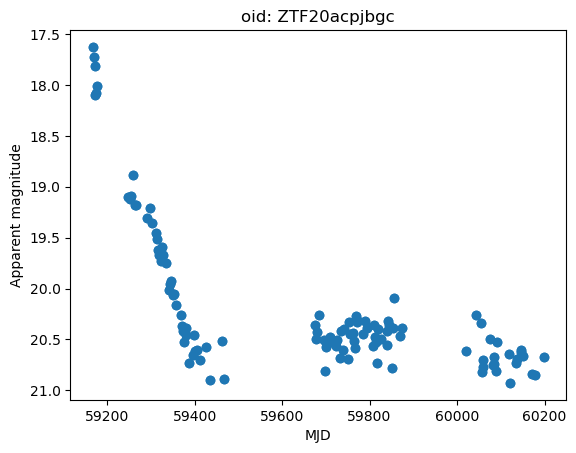

In [18]:
plot_light_curve(one_light_curve, one_light_curve.oid.unique()[0])

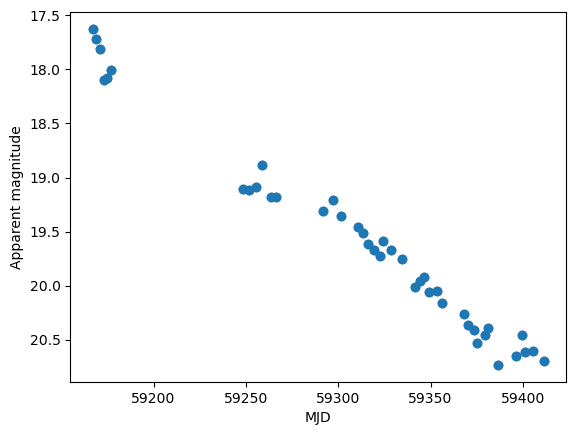

In [19]:
new_lc = process_light_curve_parsnip(one_light_curve)
plot_light_curve(new_lc)

In [20]:
p0 = [91.026,1.744,3.602,0.008,14.482,1.675,102.148,-15.984] # tpt, a0, w0, p0, m0, P, Q, R

N = 8000
time_length = 300 # days

oid = []
mjd = []
mag = []

for n in range(N):
    increase_random = np.random.random()
    oid.append(('ZTF'+str(np.random.randint(10000,20000))))
    time = np.linspace(50, 150, time_length)
    po = [p0[0] + increase_random, p0[1] + increase_random, p0[2] + 0.01*increase_random, p0[3], p0[4] + 0.01*increase_random]
          #p0[5] + 0.01*increase_random, p0[6] + 0.01*increase_random, p0[7] + 0.01*increase_random]
    #print(po)
    synthetic_lc = SinteticLigthCurve(po[0],po[1],po[2],po[3],po[4])
    f = synthetic_lc.olivares(time)
    mjd.append(np.array(time))
    mag.append(np.array(f))

# Crear una lista vacía para almacenar los datos
train_data = []

# Iterar sobre cada conjunto de tiempo y brillo
for i in range(len(mjd)):
    time_set = mjd[i]
    brightness_set = mag[i]
    code = 'ZTF' + str(i + 1)  # Código de pertenencia (del 1 al 8000)
    for time, brightness in zip(time_set, brightness_set):
        train_data.append([code, time, brightness])

# Crear el DataFrame
train_data = pd.DataFrame(train_data, columns=['oid','mjd', 'magpsf'])
train_data

,oid,mjd,magpsf
0,ZTF1,50.000000,12.373258
1,ZTF1,50.334448,12.375935
2,ZTF1,50.668896,12.378613
3,ZTF1,51.003344,12.381291
4,ZTF1,51.337793,12.383969
...,...,...,...
2399995,ZTF8000,148.662207,14.944443
2399996,ZTF8000,148.996656,14.947119
2399997,ZTF8000,149.331104,14.949794
2399998,ZTF8000,149.665552,14.952470


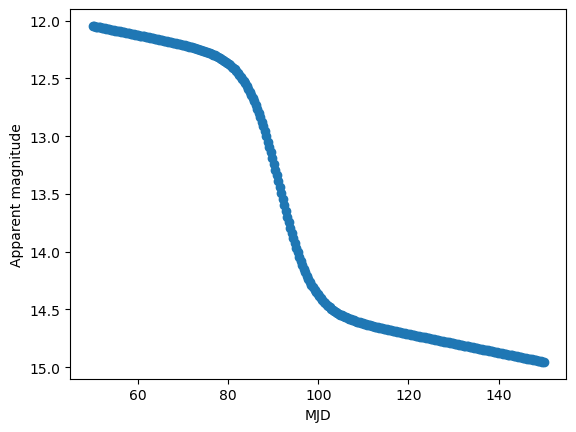

In [21]:
plot_light_curve(train_data[train_data.oid == train_data.oid.unique()[9]])

In [22]:
p0 = [91.026,1.744,3.602,0.008,14.482,1.675,102.148,-15.984] # tpt, a0, w0, p0, m0, P, Q, R

N = 2000
time_length = 300 # days

oid = []
mjd = []
mag = []

for n in range(N):
    increase_random = np.random.random()
    oid.append(('ZTF'+str(np.random.randint(10000,20000))))
    time = np.linspace(50, 150, time_length)
    po = [p0[0] + increase_random, p0[1] + increase_random, p0[2] + 0.01*increase_random, p0[3], p0[4] + 0.01*increase_random]
          #p0[5] + 0.01*increase_random, p0[6] + 0.01*increase_random, p0[7] + 0.01*increase_random]
    #print(po)
    synthetic_lc = SinteticLigthCurve(po[0],po[1],po[2],po[3],po[4])
    f = synthetic_lc.olivares(time)
    mjd.append(np.array(time))
    mag.append(np.array(f))

# Crear una lista vacía para almacenar los datos
test_data = []

# Iterar sobre cada conjunto de tiempo y brillo
for i in range(len(mjd)):
    time_set = mjd[i]
    brightness_set = mag[i]
    code = 'ZTF' + str(8000 + i + 1)  # Código de pertenencia (del 1 al 8000)
    for time, brightness in zip(time_set, brightness_set):
        test_data.append([code, time, brightness])

# Crear el DataFrame
test_data = pd.DataFrame(test_data, columns=['oid','mjd', 'magpsf'])
test_data

,oid,mjd,magpsf
0,ZTF8001,50.000000,12.308783
1,ZTF8001,50.334448,12.311461
2,ZTF8001,50.668896,12.314139
3,ZTF8001,51.003344,12.316817
4,ZTF8001,51.337793,12.319495
...,...,...,...
599995,ZTF10000,148.662207,14.943274
599996,ZTF10000,148.996656,14.945949
599997,ZTF10000,149.331104,14.948625
599998,ZTF10000,149.665552,14.951300


In [23]:
class ResidualBlock(nn.Module):

    def __init__(self, )

SyntaxError: expected ':' (3004999847.py, line 3)

In [34]:
class VariationalAutoEncoder(nn.Module):

    def __init__(self, input_dim, hidden_dim, latent_dim, device):
        super().__init__()

        # encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(0.2),
            nn.Linear(hidden_dim, latent_dim),
            nn.ReLU(0.2)
            )

        # latent mean and variance
        self.mean_layer = nn.Linear(latent_dim, 2)
        self.logvar_layer = nn.Linear(latent_dim, 2)

        # decoder
        self.decoder = nn.Sequential(
            nn.Linear(2, latent_dim),
            nn.ReLU(0.2),
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(0.2),
            nn.Linear(hidden_dim, input_dim),
            #nn.Sigmoid()
            )

    def encode(self, x):
        x = self.encoder(x)
        #print('Entro al Encoder')
        mean, logvar = self.mean_layer(x), self.logvar_layer(x)
        return mean, logvar

    def reparameterization(self, mean, var):
        #print('Esta parametrizando al Encoder')
        epsilon = torch.randn_like(var).to(device)
        z = mean + var*epsilon
        return z

    def decode(self, x):
        #print('Entro al DeEncoder')
        return self.decoder(x)

    def forward(self, x):
        mean, logvar = self.encode(x)
        z = self.reparameterization(mean, logvar)
        x_hat = self.decode(z)
        return x_hat, mean, logvar

In [77]:
input_dim = 2
h_dim = 200
z_dim = 20
num_epoch = 100
batch_size = 32
#lr_rate = 3e-4  # Karpathy constant is just a joke
lr_rate = 1e-4 

model = VariationalAutoEncoder(input_dim=input_dim, hidden_dim=h_dim, latent_dim=z_dim, device=device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr_rate)
loss_fn = nn.MSELoss()

In [40]:
from torchinfo import summary
summary(model)

Layer (type:depth-idx)                   Param #
VariationalAutoEncoder                   --
├─Sequential: 1-1                        --
│    └─Linear: 2-1                       600
│    └─ReLU: 2-2                         --
│    └─Linear: 2-3                       4,020
│    └─ReLU: 2-4                         --
├─Linear: 1-2                            42
├─Linear: 1-3                            42
├─Sequential: 1-4                        --
│    └─Linear: 2-5                       60
│    └─ReLU: 2-6                         --
│    └─Linear: 2-7                       4,200
│    └─ReLU: 2-8                         --
│    └─Linear: 2-9                       402
Total params: 9,366
Trainable params: 9,366
Non-trainable params: 0

In [27]:
X = train_data[train_data.oid == train_data.oid.unique()[0]][['mjd','magpsf']]
X = torch.tensor(X.values, dtype=torch.float32)
X.T.shape

torch.Size([2, 300])

In [78]:
train_losses = []
for epoch in tqdm(range(num_epoch)):
    # Set the model to training mode
    model.train()

    for oid, group_oid in train_data.groupby(by='oid'):
        X = group_oid[['mjd','magpsf']]
        #X = process_light_curve_parsnip(X)
        X = torch.tensor(X.values, dtype=torch.float32)
        #print(X.shape)
        # Forward pass
        #X = X.to(device)
        # Asumiendo que tu modelo devuelve X_reconst, mu y sigma
        #try:
        X_reconst, mu, sigma = model(X)

        # Cálculo de la pérdida
        reconst_loss = loss_fn(X_reconst, X)
        kl_div = -0.5 * torch.sum(1 + torch.log(sigma.pow(2)) - mu.pow(2) - sigma.pow(2))  # Corregido el coeficiente de 0.5

        # Backprop y optimización
        loss = reconst_loss + kl_div
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        #print('Paso una vez')
        #except:
        #    print(f'No se pudo con {oid}')
        #    pass
    
    train_losses.append(loss.item())
        
    # Puedes añadir un mensaje de final de epoch aquí si lo deseas
    #if epoch % 10 == 0:
    print(f'Epoch [{epoch+1}/{num_epoch}], Loss: {loss.item():.4f}')

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [1/100], Loss: 330.8398
Epoch [2/100], Loss: 316.9112
Epoch [3/100], Loss: 303.4310
Epoch [4/100], Loss: 293.9406
Epoch [5/100], Loss: 288.8968
Epoch [6/100], Loss: 305.0342
Epoch [7/100], Loss: 287.9294
Epoch [8/100], Loss: 306.7323
Epoch [9/100], Loss: 301.5240
Epoch [10/100], Loss: 290.6835
Epoch [11/100], Loss: 302.2551
Epoch [12/100], Loss: 313.8537
Epoch [13/100], Loss: 296.1223
Epoch [14/100], Loss: 304.1171
Epoch [15/100], Loss: 297.5892
Epoch [16/100], Loss: 313.1907
Epoch [17/100], Loss: 290.8970
Epoch [18/100], Loss: 299.2047
Epoch [19/100], Loss: 308.2111
Epoch [20/100], Loss: 292.2975
Epoch [21/100], Loss: 317.3180
Epoch [22/100], Loss: 321.0199
Epoch [23/100], Loss: 296.2778
Epoch [24/100], Loss: 304.0075
Epoch [25/100], Loss: 288.0457
Epoch [26/100], Loss: 277.6119
Epoch [27/100], Loss: 278.3181
Epoch [28/100], Loss: 293.2188
Epoch [29/100], Loss: 286.4052
Epoch [30/100], Loss: 293.3277
Epoch [31/100], Loss: 299.8431
Epoch [32/100], Loss: 289.1748
Epoch [33/100], L

Text(0, 0.5, 'Train loss')

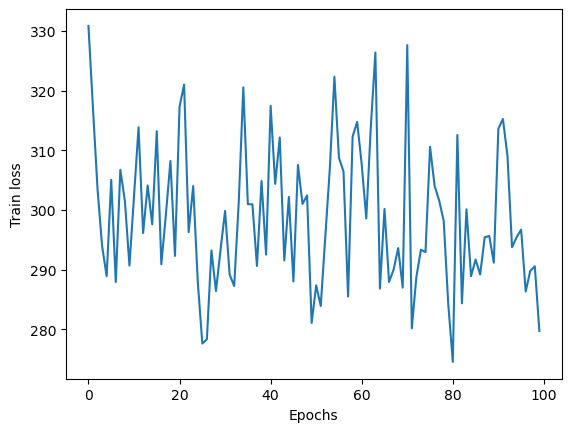

In [79]:
fig, ax = plt.subplots()
ax.plot(np.arange(num_epoch), train_losses)
ax.set_xlabel('Epochs')
ax.set_ylabel('Train loss')

In [80]:
def plot_curves(time, original_magnitude, reconstructed_magnitude, title='Curvas Originales y Reconstruidas'):
    plt.figure(figsize=(12, 6))
    plt.plot(time, original_magnitude, label='Original', linestyle='--', color='blue')
    plt.plot(time, reconstructed_magnitude, label='Reconstruido', linestyle='-', color='red')
    plt.xlabel('Tiempo')
    plt.ylabel('Magnitud')
    plt.title(title)
    plt.legend()
    plt.show()

In [89]:
model.eval()

# Definir una lista para almacenar las pérdidas de cada muestra de prueba
test_losses = []

# Definir una lista para almacenar las reconstrucciones de las muestras de prueba
reconstructions = []

#with torch.inference_mode():
with torch.inference_mode():
    for _, group_oid in test_data.groupby(by='oid'):
        X = group_oid[['mjd','magpsf']]
        time = X['mjd'].values
        original_magnitude = X['magpsf'].values
        #X = process_light_curve_atat(X)# Karpathy constant is just a joke
        X = torch.tensor(X.values, dtype=torch.float32)

        # Forward pass
        X_reconstructed, mu, logvar = model(X)

        #print(X_reconstructed)
        # Convierte las predicciones a numpy
        #reconstructed_magnitude = X_reconstructed.cpu().numpy()[:,1]  # Segunda fila para magnitud
        #print(len(reconstructed_magnitude))
        
        # Grafica
        #plot_curves(time, original_magnitude, reconstructed_magnitude, title=f'Curvas para OID {oid}')
        
        # Sal de la iteración si solo deseas graficar para un OID
        #break

        # Compute loss
        reconstruction_loss = loss_fn(X_reconstructed, X)
        kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        loss = reconstruction_loss + kl_div

        # Guardar la pérdida y las reconstrucciones
        test_losses.append(loss.item())
        reconstructions.append(X_reconstructed.cpu().numpy())

    # Calcular la pérdida promedio en los datos de prueba
    average_test_loss = np.mean(test_losses)
    print("Average test loss:", average_test_loss)

Average test loss: 327.50892308044433


In [90]:
reconstructions = np.array(reconstructions)
len(reconstructions[0][:,0]), len(reconstructions[0][:,1])

(300, 300)

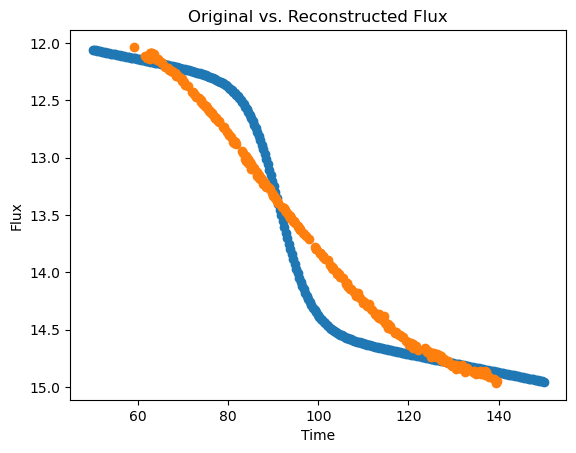

In [91]:
sample_index = 1
sample_data = test_data[test_data.oid == test_data.oid.unique()[sample_index]]
sample_reconstruction = reconstructions[sample_index]

fig, ax = plt.subplots()

ax.plot(sample_data.mjd.to_numpy(), sample_data.magpsf.to_numpy(), 'o', color='C0')
ax.plot(sample_reconstruction[:,0], sample_reconstruction[:,1], 'o', color='C1')

ax.set_xlabel('Time')
ax.set_ylabel('Flux')
ax.set_title('Original vs. Reconstructed Flux')
#ax.legend()
ax.invert_yaxis()
plt.show()